# Custom fitting example

This is a short example for fitting data, which is not covered by the fitting widget.
It relies on calling lmfit manually. Therefore one needs to provide a fitting function, which calculates the numerical residual between measurement and model.
This notebook is about fitting multiple datasets from different angles of incidents simultaneously, but can be adapted to a wide range of different use cases.

In [1]:
import numpy as np
import elli
from elli.fitting import ParamsHist
from lmfit import minimize, fit_report
import matplotlib.pyplot as plt

## Data import

Read Ψ (psi) and Δ (delta) ellipsometric spectra for different angles from a NeXus file, limited to a wavelength range of 210–800 nm, to be compatible with a tabulated Silicon dispersion.

In [2]:
data = elli.read_nexus_psi_delta("SiO2onSi.ellips.nxs").loc[(slice(None), slice(210, 800)), :]
lbda = data.loc[50].index.get_level_values("Wavelength").to_numpy()
data

Ψ           Δ
Angle of Incidence Wavelength                       
50                 210.0       40.028156  146.370560
                   211.0       40.012478  146.607407
                   212.0       40.007420  146.799438
                   213.0       40.005928  147.055832
                   214.0       40.001190  147.294281
...                                  ...         ...
70                 796.0        9.051100  174.423874
                   797.0        9.054414  174.494553
                   798.0        9.044289  174.405136
                   799.0        9.048944  174.376541
                   800.0        9.021362  174.418228

[1773 rows x 2 columns]

## Setting up invariant materials and fitting parameters

Set up the optical constants for the substrate from RII and define initial fit parameters for the Cauchy SiO₂ layer.

In [3]:
rii_db = elli.db.RII()
Si = rii_db.get_mat("Si", "Aspnes")

params = ParamsHist()
params.add("SiO2_n0", value=1.452, min=-100, max=100, vary=True)
params.add("SiO2_n1", value=36.0, min=-40000, max=40000, vary=True)
params.add("SiO2_n2", value=0, min=-40000, max=40000, vary=False)
params.add("SiO2_k0", value=0, min=-100, max=100, vary=False)
params.add("SiO2_k1", value=0, min=-40000, max=40000, vary=False)
params.add("SiO2_k2", value=0, min=-40000, max=40000, vary=False)
params.add("SiO2_d", value=20, min=0, max=40000, vary=True)

## Model helper function

This model helper function is not strictly needed, but simplifies the fit function, as the model only needs to be defined once.

In [4]:
def model(lbda, angle, params):
    SiO2 = elli.Cauchy(
        params["SiO2_n0"],
        params["SiO2_n1"],
        params["SiO2_n2"],
        params["SiO2_k0"],
        params["SiO2_k1"],
        params["SiO2_k2"],
    ).get_mat()

    structure = elli.Structure(
        elli.AIR,
        [elli.Layer(SiO2, params["SiO2_d"])],
        Si,
    )

    return structure.evaluate(lbda, angle, solver=elli.Solver2x2)

## Defining the fit function

The fit function follows the protocol defined by the lmfit package and needs the parameters dictionary as first argument.
It has to return a residual value, which will be minimized. Here psi and delta are used across all angles to calculate the residual, but could be changed to transmission or reflection data.

In [5]:
def fit_function(params, lbda, data):
    residual = []

    for phi_i in [50, 60, 70]:
        model_result = model(lbda, phi_i, params)

        resid_psi = data.loc[(phi_i, "Ψ")].to_numpy() - model_result.psi
        resid_delta = data.loc[(phi_i, "Δ")].to_numpy() - model_result.delta

        residual.append(resid_psi)
        residual.append(resid_delta)

    return np.concatenate(residual)

## Running the fit

The fitting is performed by calling the minimize function with the fit_function and the needed arguments. 
It is possible to change the underlying algorithm by providing the method kwarg.
The fit_report function provides fitted values, uncertainties, and goodness-of-fit statistics.

In [6]:
out = minimize(fit_function, params, args=(lbda, data), method="leastsq")
print(fit_report(out))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 119
    # data points      = 3546
    # variables        = 3
    chi-square         = 157.748841
    reduced chi-square = 0.04452409
    Akaike info crit   = -11031.1779
    Bayesian info crit = -11012.6572
[[Variables]]
    SiO2_n0:  1.63549687 +/- 0.03012997 (1.84%) (init = 1.452)
    SiO2_n1:  27.6408772 +/- 8.75248306 (31.66%) (init = 36)
    SiO2_n2:  0 (fixed)
    SiO2_k0:  0 (fixed)
    SiO2_k1:  0 (fixed)
    SiO2_k2:  0 (fixed)
    SiO2_d:   1.75831329 +/- 0.02404272 (1.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(SiO2_n0, SiO2_d)  = -0.9916
    C(SiO2_n0, SiO2_n1) = -0.9596
    C(SiO2_n1, SiO2_d)  = +0.9259


/home/marius/.venv/pyelli/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


##  Plotting the results

The measurent results are displayed as scatter plot and the PyElli results are overlayed as solid lines.

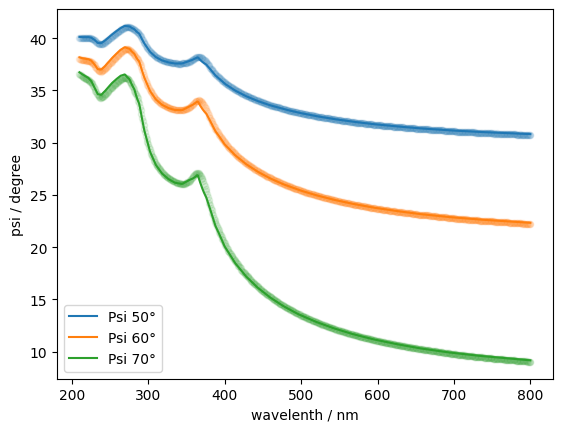

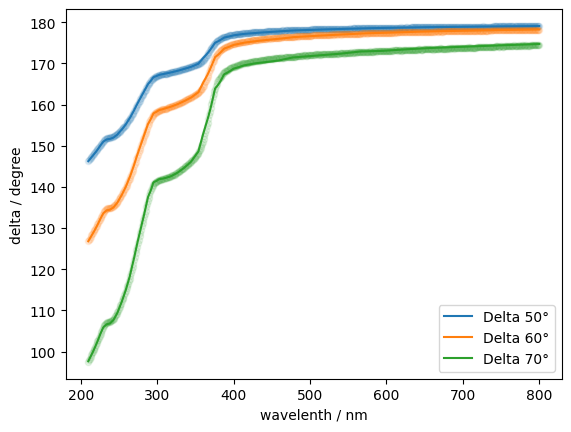

In [7]:
fit_50 = model(lbda, 50, out.params)
fit_60 = model(lbda, 60, out.params)
fit_70 = model(lbda, 70, out.params)

fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(lbda, data.loc[(50, "Ψ")], s=20, alpha=0.1, label="50° Measurement")
ax.scatter(lbda, data.loc[(60, "Ψ")], s=20, alpha=0.1,  label="Psi 60° Measurement")
ax.scatter(lbda, data.loc[(70, "Ψ")], s=20, alpha=0.1,  label="Psi 70° Measurement")
psi50, = ax.plot(lbda, fit_50.psi, c="tab:blue", label="Psi 50°")
psi60, = ax.plot(lbda, fit_60.psi, c="tab:orange", label="Psi 60°")
psi70, = ax.plot(lbda, fit_70.psi, c="tab:green", label="Psi 70°")
ax.set_xlabel('wavelenth / nm')
ax.set_ylabel('psi / degree')
ax.legend(handles=[psi50, psi60, psi70], loc='lower left')
fig.canvas.draw()

fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(lbda, data.loc[(50, "Δ")], s=20, alpha=0.1, label="Delta 50° Measurement")
ax.scatter(lbda, data.loc[(60, "Δ")], s=20, alpha=0.1,  label="Delta 60° Measurement")
ax.scatter(lbda, data.loc[(70, "Δ")], s=20, alpha=0.1,  label="Delta 70° Measurement")
delta50, = ax.plot(lbda, fit_50.delta, c="tab:blue", label="Delta 50°")
delta60, = ax.plot(lbda, fit_60.delta, c="tab:orange", label="Delta 60°")
delta70, = ax.plot(lbda, fit_70.delta, c="tab:green", label="Delta 70°")
ax.set_xlabel('wavelenth / nm')
ax.set_ylabel('delta / degree')
ax.legend(handles=[delta50, delta60, delta70], loc='lower right')
fig.canvas.draw()